In [1]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 10, 10

In [2]:
import test_models

Using TensorFlow backend.


In [3]:
import libs.raw_loader
import libs.img_argument
import libs.patch_sequancer
import test_models

In [45]:
# loads test data, prepares it and applies the trained models on the data
def load_image(img_id):
    img = np.load("raw/%s_3band_in.npz" % img_id)["arr_0"]
    return img / 255.0

def load_chan(img_id, chan):
    train_mask = np.load("raw/%s_3band_chan%d.npz" % (img_id,chan))["arr_0"] * 1.0
    return train_mask

In [19]:
img_id="6100_2_2"

In [20]:
img = load_prepare_image(img_id)

In [21]:
img.shape

(3349, 3391, 3)

In [22]:
img.dtype

dtype('float64')

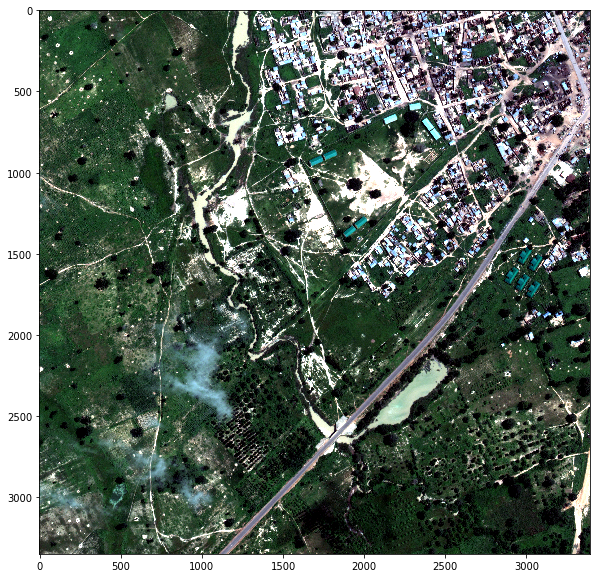

In [23]:
plt.imshow(img)

In [28]:
patch_size = 100
patch_edge =  5    # +/- 5 pixels to interpolate prediction edges  
patcher = libs.patch_sequancer.PatchInterpolationSequancer(patch_size,patch_edge,3,1)

1 : 'Bldg',
2 : 'Struct',
3 : 'Road',
4 : 'Track',
5 : 'Trees',
6 : 'Crops',
7 : 'Fast H20',
8 : 'Slow H20',
9 : 'Truck',
10 : 'Car',

In [117]:
#chan10- cars
# 666  418c10f118b988a65a2a61bf2eaf676a102939d2     0.9753      1.000  14000.0   test_mode

#chan5 - trees
# 686  0461baba6ebaccd368616258493fc0da394bb055     0.7584   1.000000      5.0   test_model3
# 160  deb2939ae51c9bc05465cd82849529725315eb66     0.6865   0.994714  14000.0   test_model2

#chan 3 - roads
# 601  779edc7c9bea66b60b641d8b383b28b4b26c8feb     0.9541   1.000000      2.0   test_model1
model_hash = "779edc7c9bea66b60b641d8b383b28b4b26c8feb"


specs = np.load("outputs2/%s_metrics.npy" % model_hash).item()
print specs

{'chan': 3, 'tag': '779edc7c9bea66b60b641d8b383b28b4b26c8feb', 'train': {'acc': 1.0, 'loss': 0.011377720162272453, 'recall': array([ 1.,  1.]), 'support': array([1, 1]), 'prec': array([ 1.,  1.]), 'mse': 0.00025309099073211883, 'fscore': array([ 1.,  1.])}, 'samples': 2, 'model': {'ident': 'test_model1', 'patch_size': 100}, 'valid': {'acc': 0.95409999999999995, 'loss': 0.65246781077893101, 'recall': array([ 0.98962763,  0.        ]), 'support': array([9641,  359]), 'prec': array([ 0.96373737,  0.        ]), 'mse': 0.043916693953219114, 'fscore': array([ 0.97651093,  0.        ])}}


In [118]:
model_chan    = specs["chan"]
model_ident   = specs["model"]["ident"]
model_func    = test_models.models()[model_ident]
model_weights = "weights/%s_best.hdf5" % (model_hash)

In [119]:
model = model_func(100,3)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 30000)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 30001     
Total params: 30,001
Trainable params: 30,001
Non-trainable params: 0
_________________________________________________________________
None


In [120]:
model.load_weights(model_weights)

In [121]:
predict_mask = patcher(img, 1, lambda patch: model.predict(patch), shaper=lambda x: np.ones((100,100,1))*x)

   ....timing: [0.008761405944824219, 0.1618976593017578, 0.7742259502410889, 0.003789186477661133, 0.07353734970092773, 0.07488059997558594]


In [122]:
predict_mask = predict_mask.reshape(predict_mask.shape[:2])

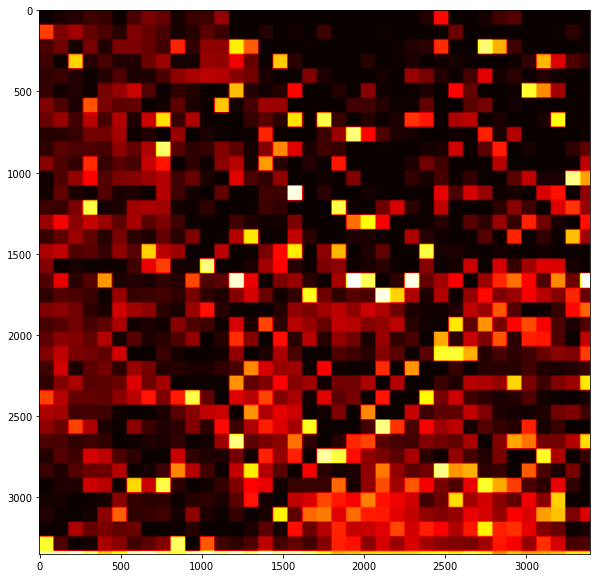

In [123]:
plt.imshow(predict_mask, cmap="hot")

In [124]:
train_mask = load_chan(img_id, model_chan)

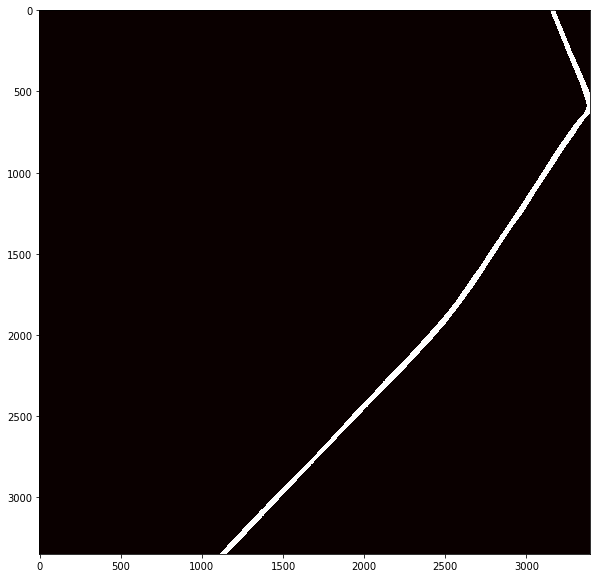

In [125]:
plt.imshow(train_mask, cmap="hot")

In [137]:
tp_match = predict_mask * train_mask

In [138]:
fp_match = predict_mask * (1.0 - train_mask)

In [139]:
fn_match = (1.0 - predict_mask) * train_mask

In [140]:
# true positives (precision - predicted true and is true)
np.sum(tp_match) / np.sum(train_mask)

0.062975740463077037

In [141]:
# false positives (precision - predicted true and is true)
np.sum(fp_match) / np.sum(1.0 - train_mask)

0.15888090678915628

In [142]:
# false negatives (??? - predicted false but is true )
np.sum(fn_match) / np.sum(train_mask)

0.93702425953692237

In [130]:
# channel 10 418c10f118b988a65a2a61bf2eaf676a102939d2 -  Pfff! .. utter garbage

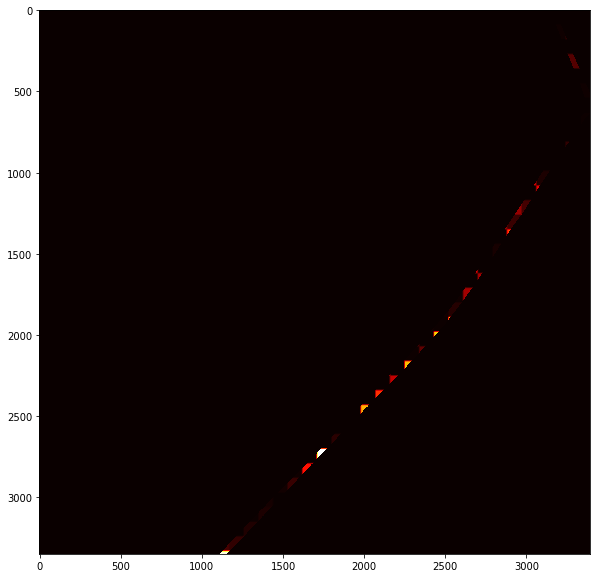

In [143]:
plt.imshow(tp_match, cmap="hot")

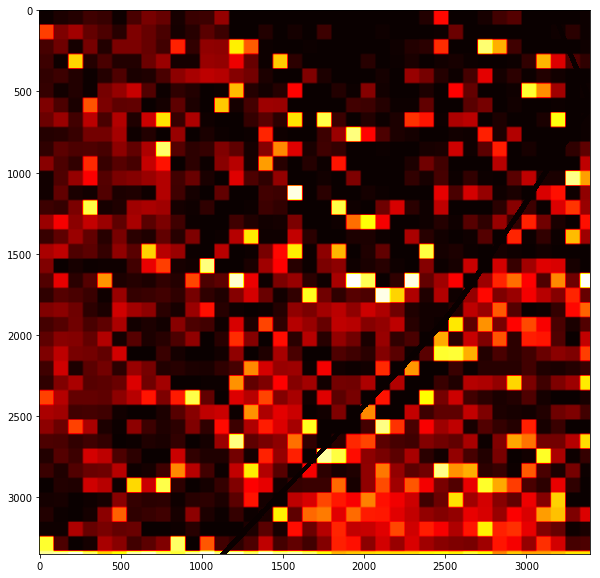

In [144]:
plt.imshow(fp_match, cmap="hot")

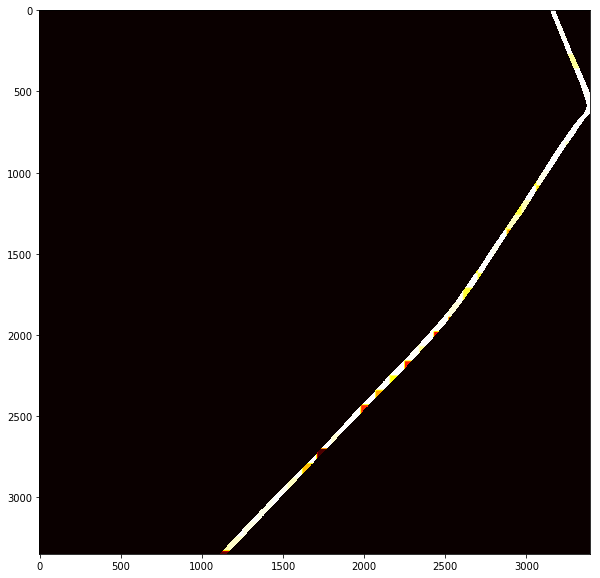

In [145]:
plt.imshow(fn_match, cmap="hot")